In [1]:
%matplotlib inline
import torch  as t
from skimage import morphology,draw
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
import scipy.ndimage
import pdb
import math
import os
from torch.autograd import Variable as V
from numpy.linalg import inv
import cv2

def affine_transform(input,mat):
    coor=coordinate_one()
    xyprime=t.tensordot(coor,t.t(mat),dims=1)
    return bilinear(input,xyprime)

def coordinate():
    coor=np.asarray(np.meshgrid(np.arange(xsize), np.arange(ysize)))
    coor=np.rollaxis(coor,0,3)
    coor=np.rollaxis(coor,0,2)
    return V(t.tensor(coor),True)

def coordinate_one():
    coor=np.asarray(np.meshgrid(np.arange(xsize), np.arange(ysize)))
    coor=np.rollaxis(coor,0,3)
    coor=np.rollaxis(coor,0,2)
    onesMatrix = np.ones((xsize,ysize,1))
    coorMatrix = np.concatenate((coor, onesMatrix), axis=2)
    return V(t.tensor(coorMatrix),True)

def nearest_neighbor(img,xyprime):
    xp=t.round(xyprime[:,:,0]).long()
    yp=t.round(xyprime[:,:,1]).long()
    xp=t.where(xp>xsize-1,t.tensor(xsize-1),xp)
    yp=t.where(yp>ysize-1,t.tensor(ysize-1),yp)
    return img[xp,yp]
    
def bilinear(img,xyprime):
    xp=xyprime[:,:,0]
    yp=xyprime[:,:,1]
    LUX=t.floor(xp).int()
    LUY=t.floor(yp).int()
    LUX=t.where(LUX>xsize-2,t.tensor(xsize-2),LUX.long())
    LUX=t.where(LUX<1,t.tensor(1),LUX)
    LUY=t.where(LUY>ysize-2,t.tensor(ysize-2),LUY.long())
    LUY=t.where(LUY<1,t.tensor(1),LUY)
    [a,b]=[yp-LUY.double(),xp-LUX.double()]
    [k00,k01,k10,k11]=[img[LUX,LUY],img[LUX,LUY+1],img[LUX+1,LUY],img[LUX+1,LUY+1]]
    return (1-b)*(a*k01+(1-a)*k00)+b*(a*k11+(1-a)*k10)

def gradient_check(img, template, matrix, gradient):
    epsilon=1e-8
    difference=t.zeros(matrix.shape)
    for i in range(len(matrix)-1):
        for j in range(len(matrix[0])):
            theltaplus=V(t.tensor(matrix),False)
            theltaminus=V(t.tensor(matrix),False)
            theltaplus[i][j]+=epsilon
            theltaminus[i][j]-=epsilon
            J_plus=t.sum((affine_transform(img,theltaplus)-template)**2).detach().numpy()
            J_minus=t.sum((affine_transform(img,theltaminus)-template)**2).detach().numpy()
            gradapprox=(J_plus-J_minus)/(2*epsilon)
            numerator = np.linalg.norm(gradient[i][j] - gradapprox) 
            denominator = np.linalg.norm(gradient[i][j]) + np.linalg.norm(gradapprox) 
            difference[i][j]=numerator/denominator
    print(difference)

def imshow(img, mov, ref):
    plt.subplot(1,3,1)
    plt.imshow(img)
    plt.title("moving")
    
    plt.subplot(1,3,2)
    plt.imshow(mov)
    plt.title("after transformation")
    
    plt.subplot(1,3,3)
    plt.imshow(ref)
    plt.title("template")
    plt.show()

In [2]:
xsize=90
ysize=100
mov=np.zeros((xsize,ysize))
mov[10:65, 16:66] = 10
mov[17:30, 18:32] = 20
mov=V(t.tensor(mov),True)

In [3]:
a=t.tensor(5).cuda()
a.cpu().detach().numpy()

array(5, dtype=int64)

tensor([[0.0375, 0.0434, 0.0380],
        [0.0389, 0.0349, 0.0360],
        [0.0000, 0.0000, 0.0000]])
tensor([[0.0353, 0.0414, 0.0359],
        [0.0362, 0.0322, 0.0335],
        [0.0000, 0.0000, 0.0000]])
tensor([[0.0334, 0.0398, 0.0341],
        [0.0340, 0.0299, 0.0313],
        [0.0000, 0.0000, 0.0000]])
tensor([[0.0318, 0.0384, 0.0326],
        [0.0321, 0.0280, 0.0295],
        [0.0000, 0.0000, 0.0000]])
tensor([[0.0304, 0.0372, 0.0313],
        [0.0305, 0.0264, 0.0279],
        [0.0000, 0.0000, 0.0000]])
tensor([[0.0292, 0.0363, 0.0301],
        [0.0291, 0.0250, 0.0266],
        [0.0000, 0.0000, 0.0000]])
tensor([[0.0281, 0.0355, 0.0291],
        [0.0280, 0.0239, 0.0255],
        [0.0000, 0.0000, 0.0000]])
tensor([[0.0272, 0.0348, 0.0283],
        [0.0271, 0.0229, 0.0246],
        [0.0000, 0.0000, 0.0000]])
tensor([[0.0264, 0.0343, 0.0275],
        [0.0263, 0.0221, 0.0238],
        [0.0000, 0.0000, 0.0000]])
tensor([[0.0257, 0.0340, 0.0268],
        [0.0257, 0.0214, 0.0231],
     

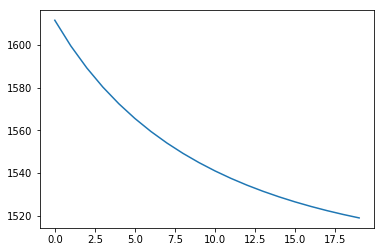

In [21]:
# MRI scale
mov=plt.imread('MRI_2D/fixed1.png')
mov=V(t.tensor(mov).double(),True)
xsize,ysize=mov.shape
angle=0
angle_sin = math.sin(angle)
angle_cos = math.cos(angle)
transformMatrix = V(t.Tensor([[1.1, -0.0, 0.0],[0.0, 1.1, 0.0],[0.0, 0.0, 1.0]]).double(),True)
template=affine_transform(mov,transformMatrix)
loss=t.sum((mov-template)**2)
loss.backward(retain_graph=True)
step=1e-8
iter=20
mat=V(t.tensor([[1.0,0.0,0.0],[0.0,1.0,0],[0.0,0.0,1.0]]).double(),True)
losses=[]
for i in range(iter):    
    tmplt=affine_transform(mov,mat)
    loss=t.sum((tmplt-template)**2)
    losses.append(loss)
    loss.backward(retain_graph=True)
    with t.no_grad():
        mat[:2,:2]-=step*mat.grad[:2,:2]
        mat[:2,2]-=step*mat.grad[:2,2]
        gradient_check(mov, template, mat.detach().numpy(), mat.grad.detach().numpy())
        mat.grad.zero_()
plt.plot(np.arange(iter), losses)


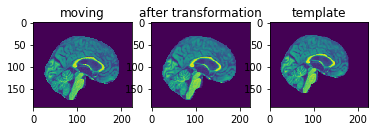

In [4]:
imshow(mov.detach().numpy(),tmplt.detach().numpy(),template.detach().numpy())

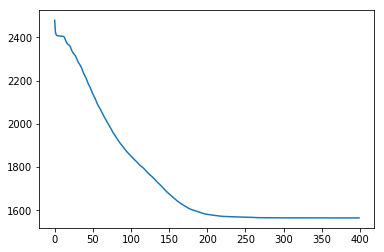

In [5]:
# MRI rotation
mov=plt.imread('MRI_2D/fixed1.png')
mov=V(t.tensor(mov).double(),True)
xsize,ysize=mov.shape
angle = 10*math.pi/180.0
angle_sin = math.sin(angle)
angle_cos = math.cos(angle)
transformMatrix = V(t.Tensor([[angle_cos, -angle_sin, -0.0],[angle_sin, angle_cos, -0.0],[0.0, 0.0, 1.0]]).double(),True)
template=affine_transform(mov,transformMatrix)
loss=t.sum((mov-template)**2)
loss.backward(retain_graph=True)
step=1e-7
iter=400
mat=V(t.tensor([[1.0,0.0,0.0],[0.0,1.0,0],[0.0,0.0,1.0]]).double(),True)
losses=[]
for i in range(iter):    
    tmplt=affine_transform(mov,mat)
    loss=t.sum((tmplt-template)**2)
    losses.append(loss)
    loss.backward(retain_graph=True)
    with t.no_grad():
        if mat.grad.sum() is 0:exit()
        mat[:2,:2]-=step*mat.grad[:2,:2]
        mat[:2,2]-=step*mat.grad[:2,2]
        mat.grad.zero_()
plt.plot(np.arange(iter), losses)


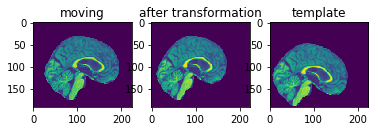

In [6]:
imshow(mov.detach().numpy(),tmplt.detach().numpy(),template.detach().numpy())

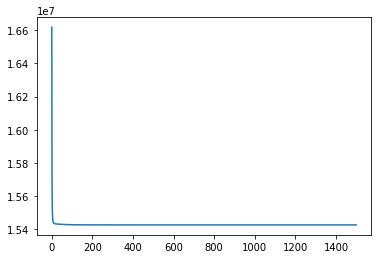

In [7]:
# hand
mov=plt.imread('hand.jpg')
mov=V(t.tensor(mov).double(),True)
xsize,ysize=mov.shape
angle = 10*math.pi/180.0
# angle=0
angle_sin = math.sin(angle)
angle_cos = math.cos(angle)
transformMatrix = V(t.Tensor([[angle_cos, -angle_sin, -0.0],[angle_sin, angle_cos, -0.0],[0.0, 0.0, 1.0]]).double(),True)
# transformMatrix = V(t.Tensor([[1.1, -0.0, 0.0],[0.0, 1.1, 0.0],[0.0, 0.0, 1.0]]).double(),True)
template=affine_transform(mov,transformMatrix)
# template=template[:,:,0]
loss=t.sum((mov-template)**2)
loss.backward(retain_graph=True)
step=1e-11
iter=1500
mat=V(t.tensor([[1.0,0.0,0.0],[0.0,1.0,0],[0.0,0.0,1.0]]).double(),True)
losses=[]
for i in range(iter):    
    tmplt=affine_transform(mov,mat)
    loss=t.sum((tmplt-template)**2)
    losses.append(loss)
    loss.backward(retain_graph=True)
    with t.no_grad():
        mat[:2,:2]-=step*mat.grad[:2,:2]
        mat[:2,2]-=step*mat.grad[:2,2]
        mat.grad.zero_()
#     if i%50==0:print(loss)
plt.plot(np.arange(iter), losses)

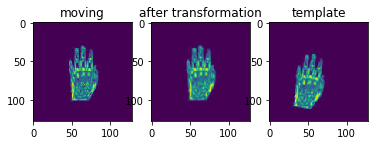

In [8]:
imshow(mov.detach().numpy(),tmplt.detach().numpy(),template.detach().numpy())


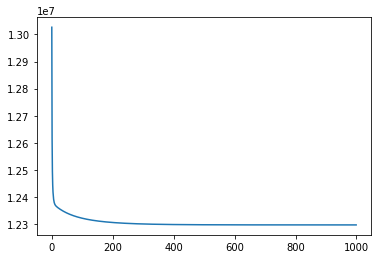

In [10]:
import scipy.ndimage as scp

angle=0*math.pi/180.0
transformMatrix = np.array([[math.cos(angle), -math.sin(angle)],[math.sin(angle), math.cos(angle)]])
transformMatrix = np.array([[0.9, 0.0],[0.0, 0.9]])

moving=np.array(plt.imread("hand.jpg"))
template=scp.affine_transform(moving,transformMatrix,offset=(10.0, 0.0))

mov=plt.imread('hand.jpg')
mov=V(t.tensor(mov).double(),True)
xsize,ysize=mov.shape
template=V(t.tensor(template).double(),True)
loss=t.sum((mov-template)**2)
loss.backward(retain_graph=True)
step=1e-11
iter=1000
mat=V(t.tensor([[1.0,0.0,0.0],[0.0,1.0,0],[0.0,0.0,1.0]]).double(),True)
losses=[]
for i in range(iter):    
    tmplt=affine_transform(mov,mat)
    loss=t.sum((tmplt-template)**2)
    losses.append(loss)
    loss.backward(retain_graph=True)
    with t.no_grad():
        mat[:2,:2]-=step*mat.grad[:2,:2]
        mat[:2,2]-=step*mat.grad[:2,2]
        mat.grad.zero_()
#     if i%50==0:print(loss)
plt.plot(np.arange(iter), losses)

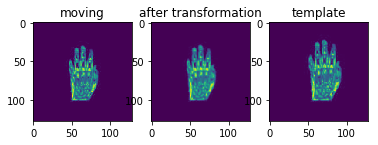

In [11]:
imshow(mov.detach().numpy(),tmplt.detach().numpy(),template.detach().numpy())

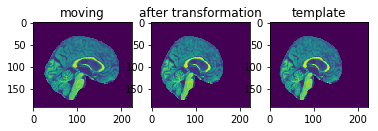